In [8]:
# Import Modules and fruit image dataset from API
import DAL
import matplotlib.pyplot as plt
import numpy as np
from numpy import *

tinyimages = DAL.create('tinyimages')
bt = tinyimages.labelled('small')


In [9]:
def gist(index):
  import DAL, leargist
  import scipy  
  from scipy import misc  
  tinyimages = DAL.create("tinyimages")
  img = scipy.misc.toimage(
    tinyimages.byid(index).reshape(32,32,3, order="F").copy())
  return leargist.color_gist(img)

from IPython.parallel import Client

rc = Client()

import time
while len(rc) < 4: 
    time.sleep(1)


dview = rc[:]
dview.retries = 10 
#calculate our gists
gists = dview.map_sync(gist, bt)


In [10]:
# define the standardization process
def standardize(x):
    import numpy as np
    m = np.mean(x)
    s = np.std(x)
    return [(y - m)/s for y in x]


# standardize gists and keep the formats in gists 
std_gists =  list(array(dview.map_sync(standardize, array(gists).T)).T)


In [11]:
# definte the function we need for K-means algorithm locally for 1000 images
def cluster_point(x):
    import numpy as np
    bestmykey = min([(i[0], (np.linalg.norm(x-mu[i[0]]))**2) for i in enumerate(mu)], key = lambda t:t[1])[0]
    return (bestmykey, x)

def distance_center(x):
    import numpy as np
    (oldmu, newmu) = x 
    return (np.linalg.norm(oldmu-newmu))**2


def distortion(y):
    import numpy as np
    (k, x) = y
    temp = mu[k]-x
    return (np.linalg.norm(temp))**2 

@dview.remote(block=True)
def reevaluate_center():
    import numpy as np
    for k in range(n):
        a = sum([i+1 for i,j in clusters if i == k])/(k+1)
        ttemp = [p for o,p in clusters if o ==k ]
        temp = ttemp[:]
        temp.append(np.zeros(960))
        b = sum(temp)
        l[k] = [a,b]
    return  l


In [12]:
# we want to try several initialization point and for several values of K 
s = [[0, np.zeros(960)]]
distortion_set = []
cluster = []
krange = range (2,9)
dview["s"] = s 
for n in krange:
     temp_cluster = []
     cost = zeros((5))
     for k in range(5):    # we iterate 5 times for 5 different initialization point
         count = 0
         distance = 100
         dview["n"] = n   
         l = [i for i in s for _ in range(n)]
         dview["l"] = l    
         import random as rnd
         mu = rnd.sample(std_gists,n)  # take k random point from gists as starting cluster-center
         while (distance > 0.01) and (count <= 100):
              dview["mu"] = mu  
              clusters = dview.map_sync(cluster_point,std_gists)
              dview.scatter('clusters', clusters)
              temp = reevaluate_center()  
              ttemp = [[sum(pparts, axis=0) for pparts in zip(*parts)] for parts in zip(*temp)]
              mu1 = [p/o for o,p in ttemp] 
              z = zip(mu,mu1)
              distance = sum(dview.map_sync(distance_center, z))
              count += 1
              mu = mu1
         temp_cluster.append(mu)
         cost[k] = sum(dview.map_sync(distortion,clusters))
     cluster.append(temp_cluster[argmin(cost)])           
     distortion_set.append(min(cost))
   



When K is 2
Cluster 1



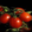
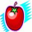
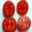
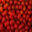
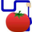
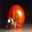
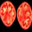
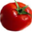
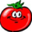
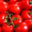
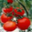
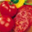
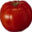
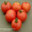
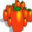
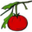
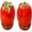
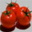
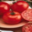
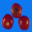
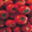
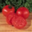
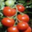
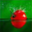
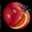
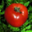
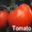
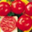
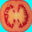
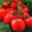
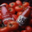
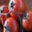
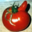
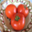
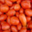
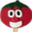
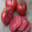
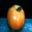
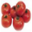
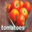
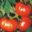
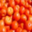
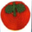
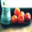
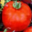
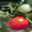
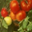
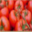
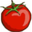
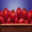
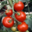
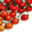
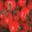
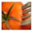
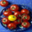
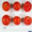
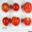
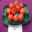
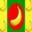
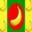
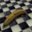
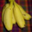
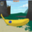
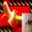
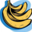
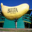
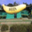
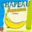
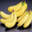
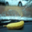
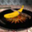
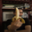
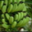
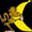
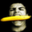
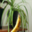
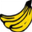
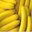
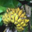
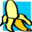
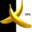
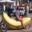
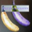

Cluster 2



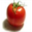
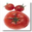
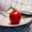
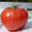
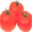
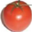
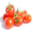
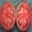
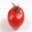
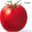
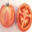
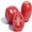
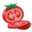
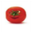
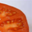
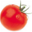
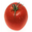
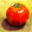
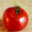
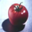
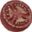
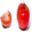
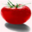
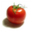
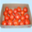
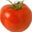
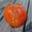
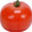
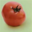
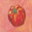
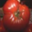
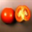
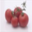
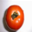
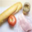
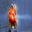
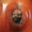
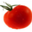
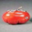
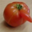
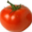
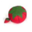
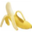
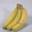
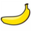
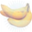
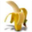
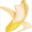
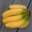
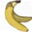
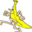
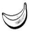
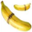
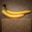
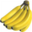
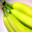
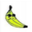
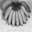
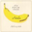
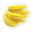
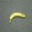
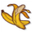
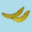
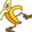
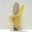
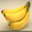
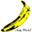
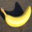
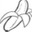
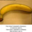
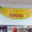
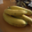
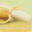
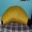
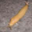
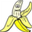
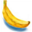
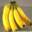
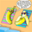
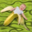
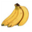
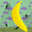
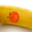
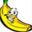
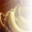
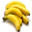
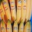
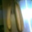
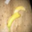
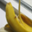
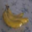
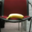
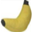
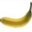
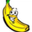
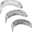
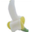
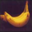
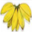
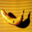
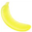
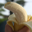
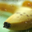
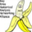
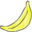
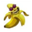
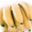
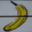
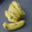
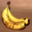
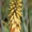
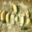
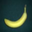
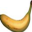
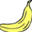
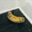
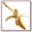

When K is 3
Cluster 1



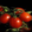
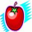
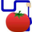
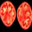
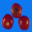
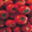
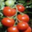
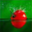
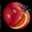
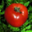
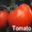
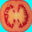
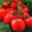
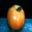
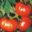
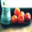
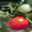
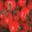
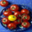
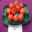
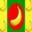
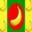
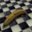
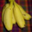
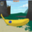
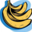
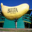
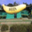
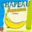
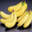
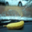
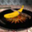
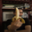
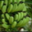
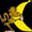
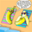
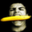
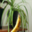
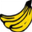
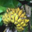
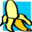
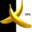
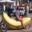
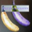

Cluster 2



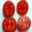
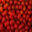
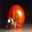
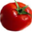
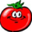
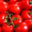
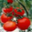
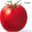
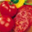
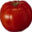
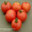
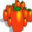
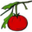
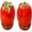
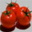
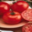
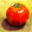
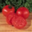
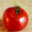
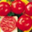
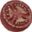
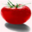
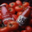
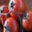
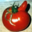
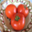
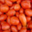
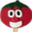
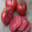
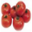
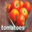
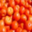
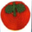
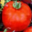
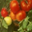
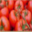
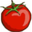
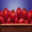
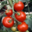
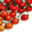
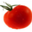
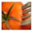
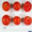
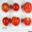
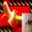
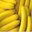

Cluster 3



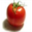
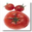
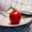
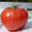
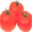
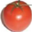
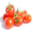
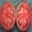
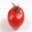
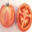
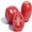
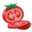
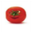
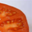
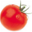
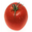
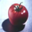
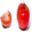
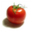
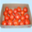
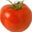
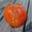
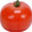
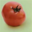
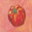
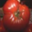
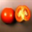
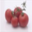
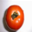
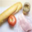
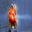
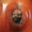
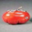
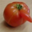
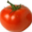
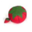
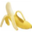
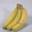
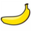
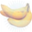
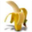
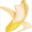
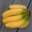
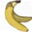
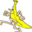
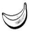
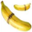
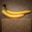
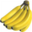
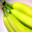
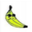
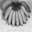
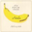
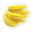
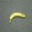
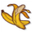
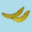
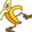
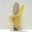
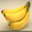
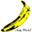
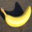
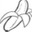
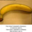
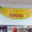
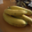
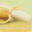
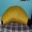
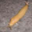
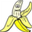
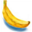
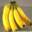
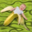
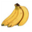
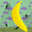
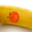
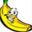
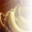
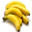
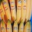
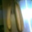
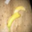
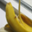
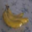
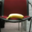
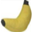
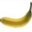
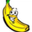
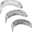
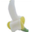
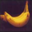
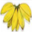
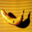
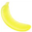
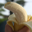
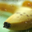
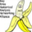
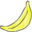
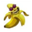
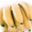
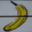
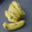
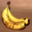
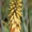
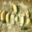
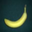
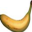
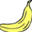
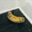
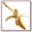

When K is 4
Cluster 1



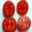
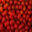
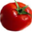
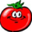
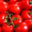
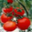
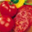
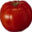
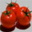
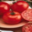
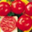
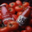
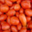
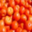
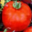
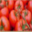
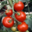
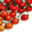
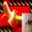

Cluster 2



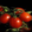
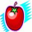
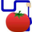
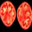
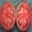
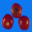
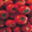
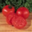
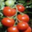
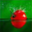
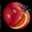
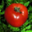
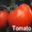
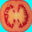
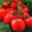
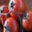
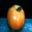
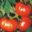
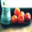
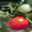
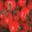
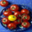
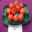
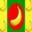
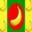
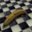
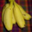
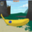
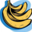
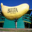
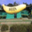
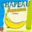
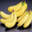
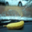
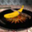
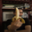
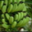
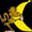
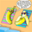
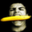
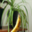
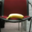
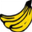
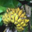
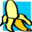
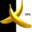
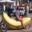
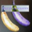

Cluster 3



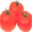
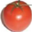
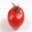
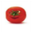
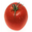
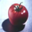
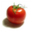
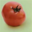
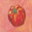
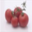
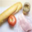
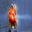
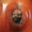
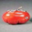
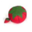
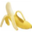
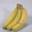
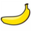
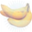
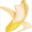
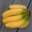
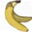
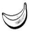
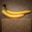
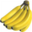
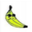
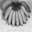
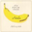
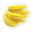
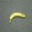
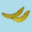
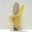
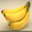
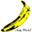
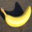
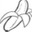
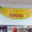
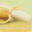
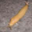
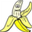
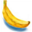
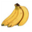
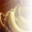
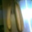
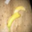
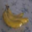
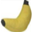
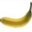
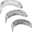
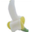
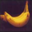
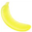
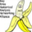
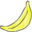
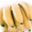
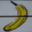
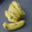
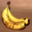
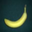
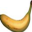
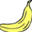
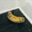
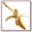

Cluster 4



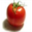
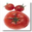
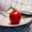
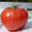
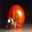
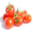
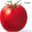
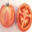
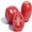
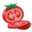
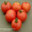
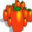
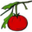
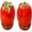
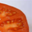
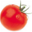
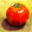
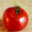
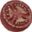
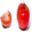
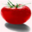
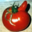
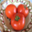
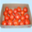
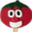
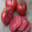
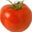
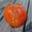
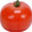
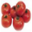
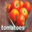
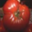
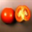
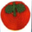
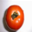
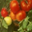
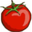
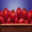
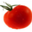
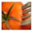
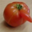
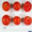
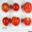
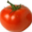
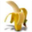
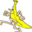
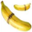
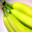
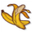
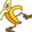
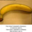
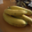
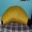
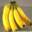
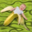
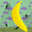
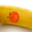
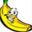
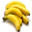
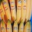
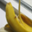
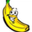
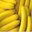
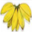
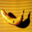
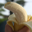
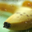
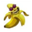
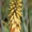
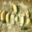

When K is 5
Cluster 1



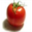
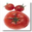
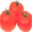
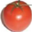
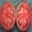
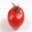
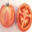
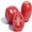
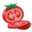
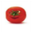
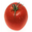
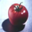
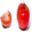
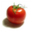
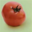
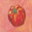
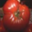
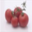
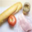
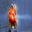
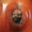
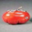
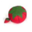
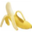
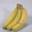
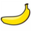
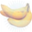
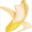
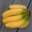
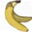
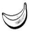
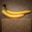
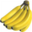
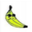
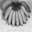
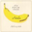
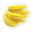
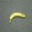
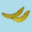
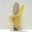
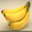
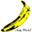
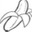
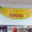
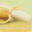
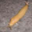
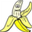
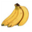
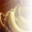
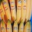
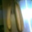
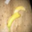
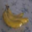
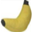
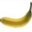
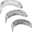
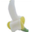
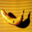
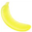
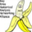
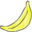
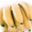
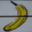
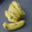
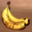
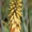
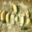
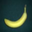
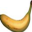
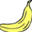
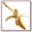

Cluster 2



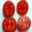
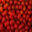
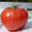
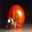
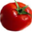
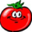
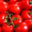
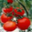
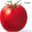
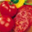
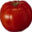
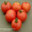
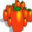
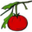
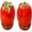
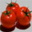
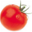
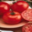
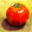
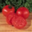
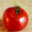
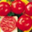
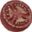
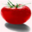
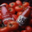
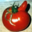
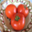
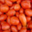
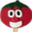
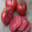
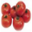
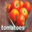
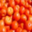
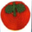
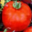
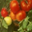
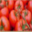
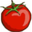
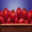
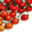
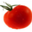
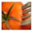
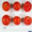
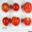
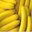

Cluster 3



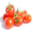
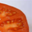
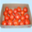
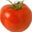
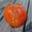
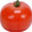
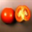
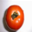
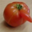
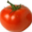
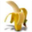
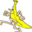
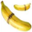
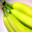
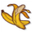
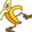
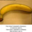
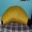
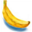
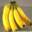
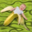
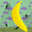
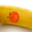
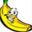
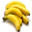
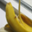
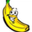
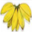
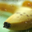
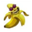

Cluster 4



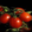
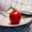
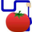
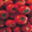
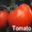
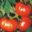
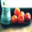
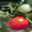
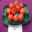
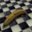
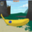
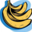
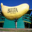
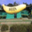
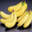
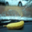
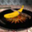
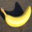
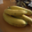
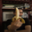
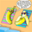
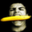
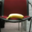
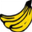
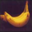
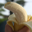
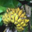
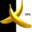
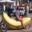
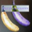
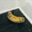

Cluster 5



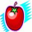
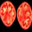
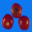
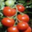
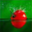
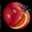
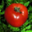
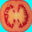
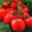
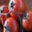
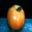
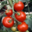
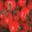
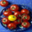
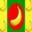
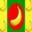
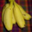
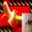
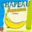
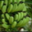
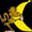
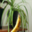
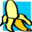

When K is 6
Cluster 1



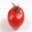
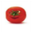
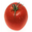
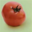
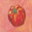
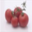
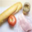
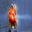
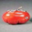
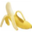
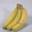
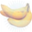
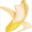
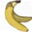
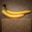
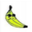
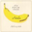
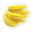
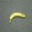
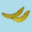
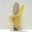
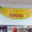
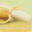
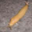
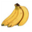
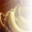
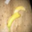
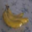
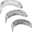
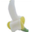
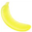
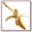

Cluster 2



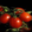
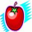
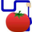
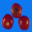
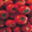
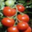
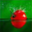
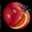
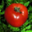
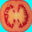
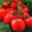
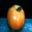
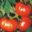
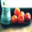
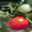
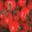
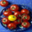
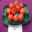
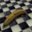
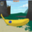
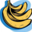
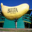
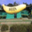
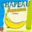
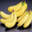
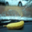
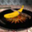
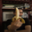
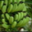
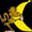
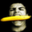
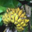
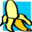
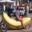
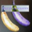

Cluster 3



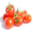
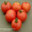
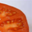
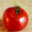
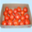
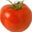
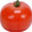
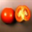
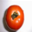
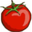
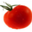
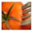
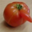
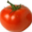
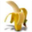
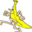
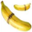
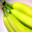
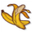
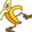
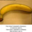
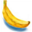
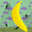
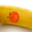
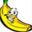
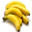
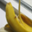
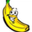
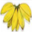
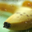
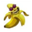

Cluster 4



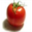
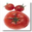
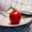
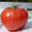
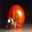
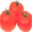
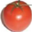
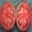
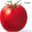
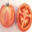
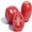
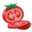
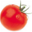
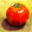
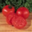
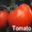
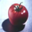
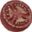
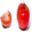
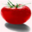
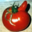
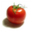
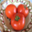
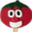
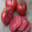
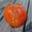
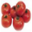
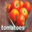
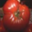
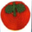
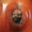
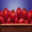
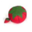
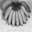
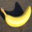
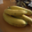
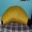
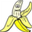
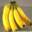
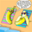
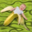
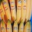
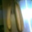
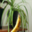
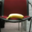
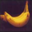
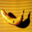
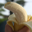
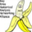
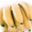
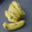
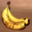
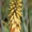
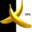
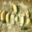
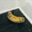

Cluster 5



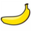
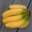
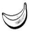
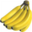
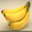
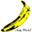
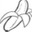
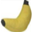
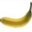
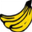
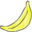
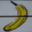
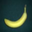
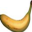
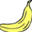

Cluster 6



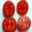
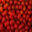
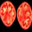
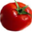
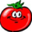
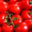
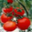
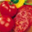
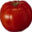
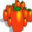
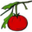
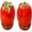
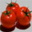
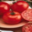
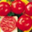
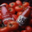
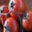
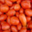
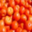
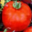
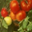
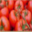
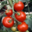
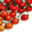
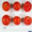
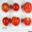
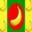
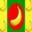
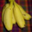
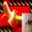
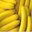

When K is 7
Cluster 1



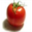
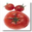
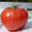
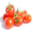
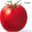
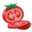
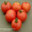
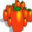
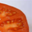
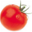
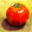
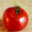
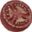
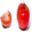
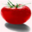
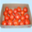
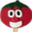
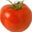
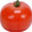
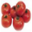
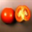
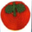
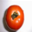
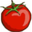
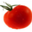
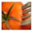
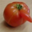
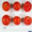
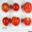
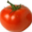
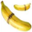
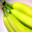
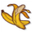
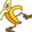
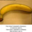
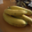
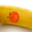
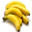
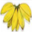
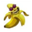

Cluster 2



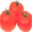
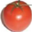
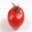
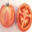
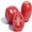
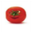
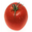
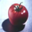
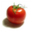
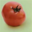
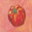
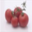
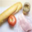
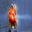
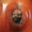
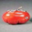
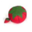
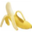
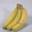
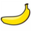
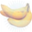
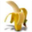
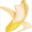
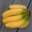
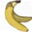
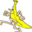
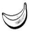
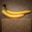
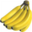
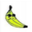
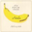
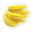
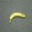
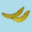
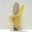
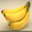
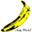
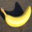
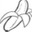
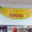
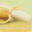
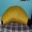
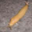
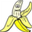
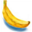
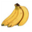
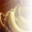
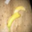
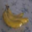
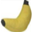
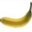
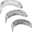
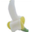
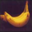
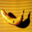
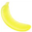
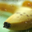
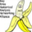
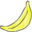
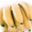
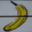
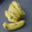
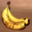
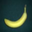
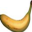
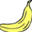
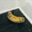
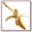

Cluster 3



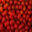
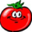
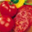
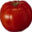
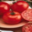
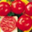

Cluster 4



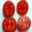
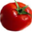
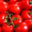
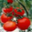
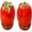
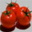
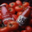
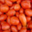
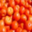
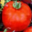
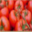
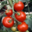
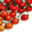
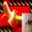

Cluster 5



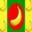
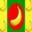

Cluster 6



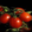
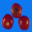
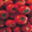
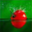
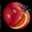
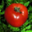
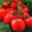
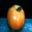
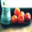
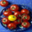
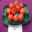
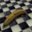
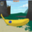
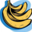
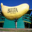
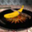
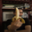
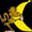
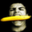
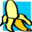

Cluster 7



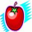
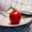
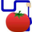
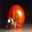
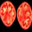
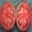
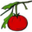
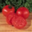
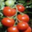
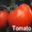
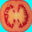
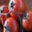
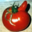
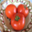
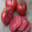
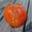
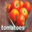
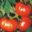
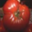
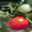
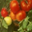
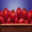
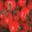
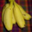
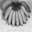
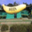
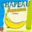
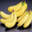
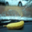
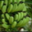
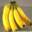
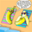
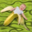
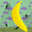
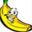
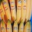
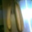
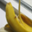
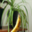
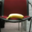
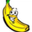
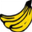
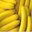
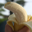
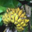
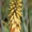
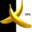
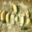
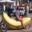
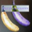

When K is 8
Cluster 1



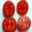
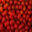
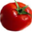
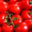
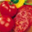
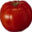
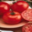
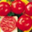
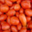
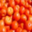
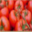
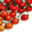
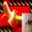

Cluster 2



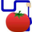
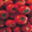
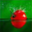
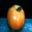
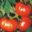
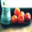
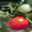
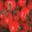
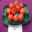
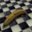
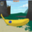
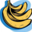
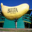
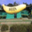
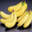
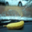
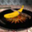
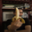
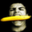
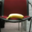
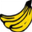
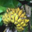
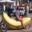
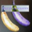

Cluster 3



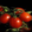
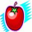
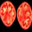
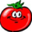
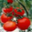
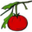
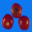
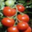
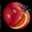
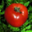
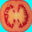
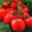
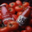
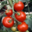
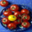
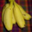
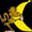
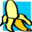

Cluster 4



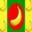
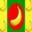

Cluster 5



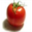
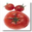
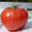
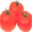
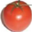
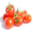
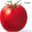
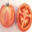
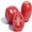
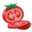
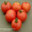
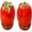
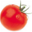
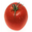
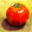
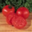
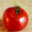
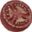
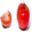
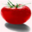
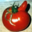
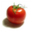
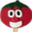
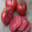
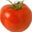
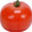
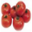
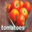
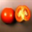
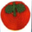
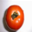
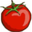
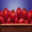
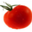
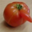
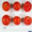
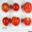
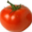
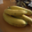

Cluster 6



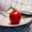
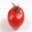
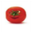
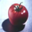
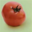
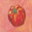
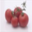
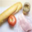
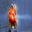
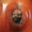
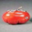
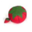
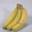
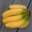
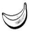
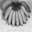
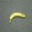
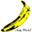
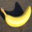
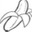
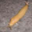
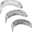
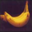
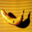
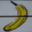
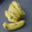
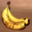
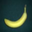
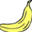
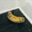

Cluster 7



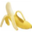
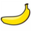
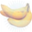
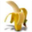
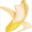
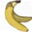
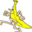
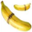
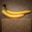
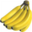
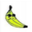
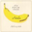
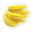
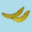
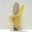
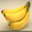
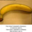
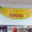
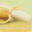
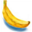
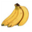
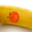
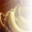
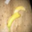
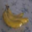
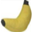
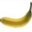
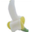
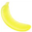
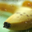
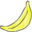
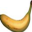
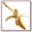

Cluster 8



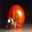
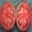
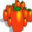
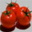
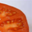
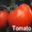
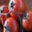
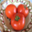
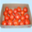
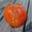
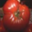
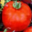
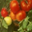
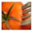
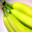
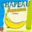
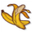
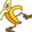
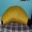
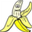
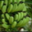
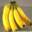
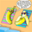
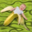
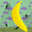
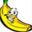
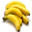
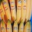
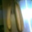
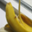
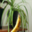
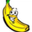
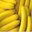
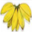
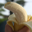
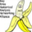
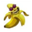
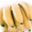
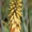
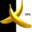
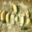

In [13]:
# Visualize the clusters 

for mu in cluster:
    dview["mu"] = mu
    clusters = dview.map_sync(cluster_point,std_gists)
    index = [i for i,j in clusters]
    com_index = zip(index,bt)
    l = len(mu)
    print "When K is %s" %l
    for x in range(l):
        print "Cluster %s" %(x+1)
        temp_index = [j for i,j in com_index if i == x]
        tinyimages.display(tinyimages.byid(temp_index)) 
    

I try to cluster the the image to by K-means Algorithm by different number of clusters, from 2 to 8. From the visualization result, there are bananas and tomatos image in the data set. And it is also not difficult to tell, there is still some mixture of tomatos and bananas in one cluster. Based on my understanding, the better clustering rule would have less that kind of mixture I metioned before. Overall, when K =5 or K = 6, from the observation of the outcomes, it might be the most approriate outcome I have found. 

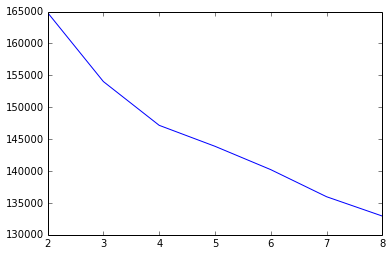

In [14]:
# Plot the relationship of K and the distortion
fig = plt.figure()
plt.plot(krange,distortion_set)               
plt.show()    



From the plots above, the distortion is approximately monotonically decreasing with the increasing of the value of K, which is the number of cluster point we choose to start.

In [1]:

# Similarly we extract amd standardize the gists at first
# definte the function we need for K-means algorithm on AWS for 1,000,000 images


import time
start_time = time.time()

tinyimages = DAL.create('tinyimages')
ids = tinyimages.labelled('large')

gists = dview.map_sync(gist, ids)

std_gists =  list(array(dview.map_sync(standardize, array(gists).T)).T)



def distance_center(x):
    import numpy as np
    (oldmu, newmu) = x 
    return (np.linalg.norm(oldmu-newmu))**2


@dview.remote(block=True)
def cluster_point():
    import numpy as np    
    s = [[[0, np.zeros(960)]]]
    l = [i for i in s for _ in range(n)]
    for x in std_gists: 
        bestmykey = min([(i[0], (np.linalg.norm(x-mu[i[0]]))**2) for i in enumerate(mu)], key = lambda t:t[1])[0]
        temp = l[bestmykey][:]
        temp.append([1,x])
        l[bestmykey] = temp[:]
    ttemp = [[sum(pparts) for pparts in zip(*parts)] for parts in l]
    return ttemp



@dview.remote(block=True)
def distortion():
    import numpy as np
    t = [[[0]]]
    m = [i for i in t for _ in range(n)]
    for x in std_gists:
        (bestmykey,bestmydis) = min([(i[0], (np.linalg.norm(x-mu[i[0]]))**2) for i in enumerate(mu)], key = lambda t:t[1])     
        temp = m[bestmykey][:]
        temp.append([bestmydis])
        m[bestmykey] = temp[:]
    ttemp = [[sum(pparts) for pparts in zip(*parts)] for parts in m]
    return ttemp



NameError: name 'DAL' is not defined

In [ ]:
distortion_set = []
krange = [2,3,5,8,12,17,20] # I take the of sevearal different value of K  
dview.scatter("std_gists", std_gists)
for n in krange:
     cost = zeros((5))
     for k in range(5):    # we iterate 4 times for 4 different initialization point
         count = 0
         distance = 100
         dview["n"] = n   
         import random as rnd
         mu = rnd.sample(std_gists,n)  # take k random point from gists as starting cluster-center
         while (distance > 0.01) and (count <= 100):
            dview["mu"] = mu
            temp = cluster_point()
            ttemp = [[sum(pparts, axis=0) for pparts in zip(*parts)] for parts in zip(*temp)]
            mu1 = [p/o for o,p in ttemp]
            z = zip(mu,mu1)
            distance = sum(dview.map_sync(distance_center, z))
            count += 1
            mu = mu1
         dview["mu"] = mu   
         cost[k] = sum(distortion())
     distortion_set.append(min(cost))       

# plot the relationship of value of K and corresponding distortion            
fig = plt.figure()
plt.plot(krange,distortion_set)               
plt.show()      


print "The total runtime would be %s minutes" %((time.time() - start_time)/60)

From the outcome above, it is basically followed the same result of the smaller data set. I choose the several K from the 1 to 20. The plot is almost monotonically dcreasing with the value of K. And it is also reason, as we have proved the distortion would as least be non-increasing with the inrease of the value of K